# My Second RNN

The purpose here is to build upon the RNN built in the previous version, RNN1.

The main aim of this notebook is to fix/minimise a lot of the main issues I encountered in RNN1. This mainly includes the tokenization quality and the model architecture. 

Better tokenization will lead to smaller one-hot encodings and a better architecture will lower the number of parameters. RNN1 had 685,523,306 parameters, causing one pass through the data taking ~10 hours. Training a model on a personal computer would be impossible.

Therefore, my main points of focus here will be to:

1. Deal with lowercase and uppercase characters
2. Deal with punctuation characters so the model can generate these as needed
3. Optimize the model architecture.

Note: The dataset I'm using here is the tiny Shakespeare dataset which can be found in [Andrej Karpathy's repository](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt).

## Imports

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

import re

# mpl.RcParams('figure.figsize') = (8,8)

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

with open('../data/shakespeare.txt') as file:
    text = file.read()

## Auxiliary functions

In [32]:
def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

## Preprocessing

I will not go through what the data looks like or explain any of the features since I went through this in RNN1.

In [33]:
punctuation_special_chars = set([char for char in text if not char.isalpha()]).difference(['\n', '3', ' '])

# the .union() in the next line allows us to separate the \n characters 
# from the words that are on the next line. This avoids single-frequency
# tokens like "\nwhiles"
for punc_char in punctuation_special_chars.union(['\n', '3']):
    # "!" -> " ! "
    text = text.replace(punc_char, ' ' + punc_char + ' ')

text = text.lower()

# the start-of-sequence and end-of-sequence tokens
vocab = set(text.split()).union(punctuation_special_chars.union(['\n', '', '<S>', '<E>']))
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 11470


Note that in RNN1, the vocab size was 25,682 and here we've narrowed it down to 11,470. This means the one-hot vector will be substantially shorter and, thus, more computationally efficient.

Removing all the duplicate spaces:

In [34]:
print(repr(text[:100]))
text = re.sub(r'\ +', ' ', text)
print(repr(text[:100]))

'first citizen :  \n before we proceed any further ,  hear me speak .  \n  \n all :  \n speak ,  speak . '
'first citizen : \n before we proceed any further , hear me speak . \n \n all : \n speak , speak . \n \n fi'


We are now ready to make an iterable of paragraphs. By "paragraphs" I more mean sort of "sections" of the text, having the format of the person speaking, followed by the paragraph that they say. 

Remember that since we converted `"\n" -> " \n "`, we now need to split by `"\n \n"`, rather than by `"\n\n"` as we did in RNN1.

In [35]:
full_text = [paragraph.strip() for paragraph in text.split('\n \n')]
for paragraph in full_text[:5]:
    print(repr(paragraph), '\n')

'first citizen : \n before we proceed any further , hear me speak .' 

'all : \n speak , speak .' 

'first citizen : \n you are all resolved rather to die than to famish ?' 

'all : \n resolved . resolved .' 

'first citizen : \n first , you know caius marcius is chief enemy to the people .' 



## Tokenizer

In this section, we want to build a tokenizer so we can convert a paragraph (string of words/tokens) to a tensor. I am making this tokenizer manually, but this is actually called a WordPiece tokenizer. 

Again, the details won't be discussed again (as they are described in RNN1 unless I add some new changes).

In [36]:
word2index = {word:i for i, word in enumerate(vocab)}
index2word = {i:word for word, i in word2index.items()}

In [73]:
def tokenize(paragraph, start_only = False):
    '''Returns the one-hot encoding of a paragraph'''
    # start_only should be set to true only for 
    # tokenizing the "<S>" character for prediction
    if not start_only:
        paragraph = '<S> ' + paragraph + ' <E>'    
    paragraph = paragraph.split(' ')
    one_hot = torch.tensor( # retrieves the indices for each word
        [word2index[word] for word in paragraph]
    )
    if start_only:
        return F.one_hot(one_hot, num_classes=vocab_size).squeeze(dim = 0)
    return F.one_hot(one_hot, num_classes=vocab_size)

def untokenize(one_hot_tensor):
    '''Takes in a one-hot encoded tensor and returns a list of corresponding words'''
    if len(one_hot_tensor.shape) == 1:
        return index2word[one_hot_tensor.item()]
    word_indices = one_hot_tensor.nonzero()[:,1]
    words = [index2word[i.item()] for i in word_indices]
    return words

The encoded representation is a vector of size `[n+2, vocab_size]`, where `n` is the number of words in the "paragraph". 

The tensor's first dimension is `n+2` because the tokenizer adds the `<S>` and `<E>` tokens to the paragraph. 

The encoding looks like this:

In [38]:
print(repr(paragraph))
print(untokenize(tokenize(paragraph)))

'first citizen : \n first , you know caius marcius is chief enemy to the people .'
['<S>', 'first', 'citizen', ':', '\n', 'first', ',', 'you', 'know', 'caius', 'marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people', '.', '<E>']


In [39]:
print(tokenize('<S>', start_only=True), end = " <=> ")
print(untokenize(tokenize('<S>', start_only=True)))

tensor([0, 0, 0,  ..., 0, 0, 0]) <=> <S>


## RNN Model

The architecture of the network has been adjusted since RNN1:

The below RNN takes in the input and the hidden state and multiplies each by a respective weight matrix. It then adds the results and adds a bias, followed by an activation, to get the new hidden state. This hidden state is then passed on as the next hidden state as well as multiplied by another learnable matrix (with added bias) to produce output. Both the output and new hidden state are returned.

This design is substantially more computationally efficient (the number of parameters is shown later in the notebook) especially when combined with the reduced encoding dimensionality.

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        # vocab_size here is equivalent to input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # weights
        self.Wxh = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.Whh = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.Why = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        
        # activations
        self.activation = nn.Tanh()
        self.softmax = nn.Softmax(dim=0)
        
        # nn.Parameter() necessary so these are recognised as model parameters
        self.bias_h = nn.Parameter(torch.randn(1)) # hidden state bias
        self.bias_y = nn.Parameter(torch.randn(1)) # output bias
        
        
    def forward(self, x, hidden_state):
        new_hidden_state = self.activation(self.Wxh(x) + self.Whh(hidden_state) + self.bias_h)
        output = self.softmax(self.activation(self.Why(new_hidden_state) + self.bias_y))
        return output, new_hidden_state

Note that I am using a higher learning rate than in RNN1 because the ADAM optimizer typically takes longer to converge than SGD. The learning rate doesn't matter too much for the purposes of this notebook, but I do want to see the loss decreasing instead of jumping around like it did in RNN1.

In [41]:
hidden_size = 1000
rnn = RNN(input_size=vocab_size, hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.5)
criterion = nn.CrossEntropyLoss()

## Training

RNN1 took 10 hours to go through the data once whereas RNN2 takes 21 minutes. This is a substantial improvement in running time and I consider this a big win.

In [191]:
n_epochs = 20

losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, paragraph in enumerate(full_text):
        one_hot_encoded = tokenize(paragraph).to(device)
        hidden_state = torch.zeros(hidden_size).to(device)
        batch_loss = torch.zeros(1).to(device)
        for input_one_hot, output_one_hot in zip(one_hot_encoded[:-1], one_hot_encoded[1:]):
            input_one_hot, output_one_hot = input_one_hot.to(device), output_one_hot.to(device)

            distribution, hidden_state = rnn(input_one_hot.float(), hidden_state)
            
            loss = criterion(distribution, output_one_hot.float())
            batch_loss += loss

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # the loss needs to be normalised since paragraphs can be of different lenghts.
        epoch_loss += batch_loss.item() / len(one_hot_encoded)

        if (i + 1) % 100 == 0:
            printf(f'Epoch: {epoch + 1}, Progress: {i+1}/{len(full_text)}, Loss: {batch_loss.item() / len(one_hot_encoded):.4f}')
    losses.append(epoch_loss)


Epoch: 20, Progress: 7200/7222, Loss: 8.7975

## Saving

In [42]:
# Saving the model
# torch.save(rnn.state_dict(), 'models/rnn2.pt')

# Loading the RNN
rnn = RNN(input_size=vocab_size, hidden_size=hidden_size).to(device)
rnn.load_state_dict(torch.load('models/rnn2.pt'))

<All keys matched successfully>

## Loss

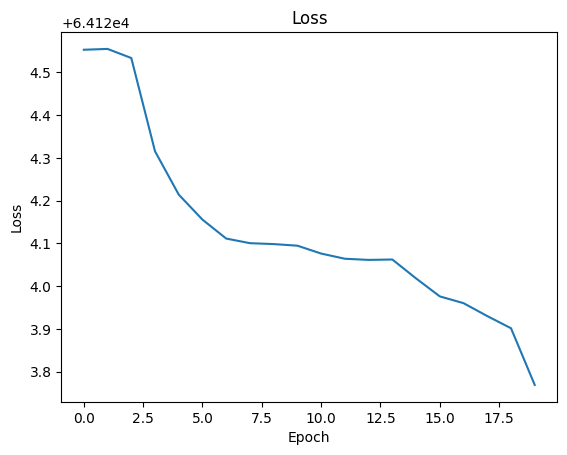

In [193]:
# The running loss is only useful across many epochs
# # Calculating the running average loss
# x_indices = [i for i in range(len(losses))  if 4 < (i) < len(losses) - 5]
# running_average = [torch.mean(torch.tensor(losses[max(0, i-5):i+6])).item() for i in range(len(losses)) if 4 < (i) < len(losses) - 5]

plt.plot(torch.arange(len(losses)), losses)
# plt.plot(x_indices, running_average)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Inference

In [87]:
# punctuation_multiplier = torch.ones(vocab_size, device = device)
# for punc_char in punctuation_special_chars:
#     index = word2index[punc_char]
#     punctuation_multiplier[index] = 500

In [83]:
generator = torch.Generator(device = device).manual_seed(127) # for reproducibility

with torch.no_grad():
    output = "<S>"
    hidden_state = torch.zeros(hidden_size).to(device)
    
    n_generated = 0
    line_counter = 0
    
    while output != '<E>' and n_generated < 500:
        output = tokenize(output, start_only=True).float().to(device)
        distribution, hidden_state = rnn(output, hidden_state)
        
        output = untokenize(torch.multinomial(distribution, 1))
        
        print(output, end = ' ')
        
        line_counter += len(output) + 1
        n_generated += 1
        
        if line_counter > 100:
            print()
            line_counter = 0

bloods mentioned boldness eloquent aristotle eyeing highness lure henceforth exploit dissolved helped 
allaying cannibally tormentors preserving vipers employ copatain choler affray jolly engine intelligencer 
unmoan definitive rushing opinion tottering positively ulysses millstones deservedly lands bide kite 
skulls recanting university trial rarities joint amazedness sith putting lamented tears aumerle wreaths 
floods revolted panting swells dries act prevail coop wonderful fallible hoarded rope horsing earn sometime 
bird emilia mules odd love peerless snatch sampson soled goodlier plagued retire roan counsellor extracting 
band northumberland bounds quest follower darest factious wholesome greedy gives natures piles greetings 
grieved trembling snatch sebastian finger suspects lavish lazy one coursers appearing early tribes apprehended 
filed fane fills annoy rejoicing pile rift award stile desperation offspring necessaries bating warrants 
joints gates plebeii applied drenched cor

# Parameters

The number of parameters in RNN2 is substantially smaller than in RNN1:

In [84]:
sum(p.numel() for p in rnn.parameters() if p.requires_grad)

23953472

I am still not saying it's a good model :)

# Final thoughts

There have been many improvements since RNN1:
1. The tokenization now deals with character case and punctuation
2. The input dimensionality has been reduced from 25,682 to 11,470
3. The model architecture is more efficient and allows training - each run through the data takes 21 minutes compared to 10 hours
4. The model is now realistically trainable
5. Softmax has been applied after a squashing activation to avoid vanishing gradients

Other thoughts:
1. The optimizer has been changed to ADAM, which usually takes longer to converge than SGD but usually performs better.
2. The model needs to be trained for many more epochs and there need to be experiments with the learning rate
3. Once the model is trained to some extent there can be exploration on the punctuation multiplier

Possible further improvements:
1. Reduce the input dimensionality further with token embeddings
2. Explore the utility of a temperature parameter to smooth out the learned distribution - there are a lot of commas in the data compared to other characters
3. Explore paragraph sampling during training?
4. Explore truncated backpropogation - for example, we can backpropogate every 100 tokens instead of backpropogating after every paragraph has been completed.
5. Increase the hidden depth
6. Increase the hidden size
7. Explore GRU/LSTM architectures
8. Explore more granular tokenizers such as byte-pair encoding
9. Explore different learning rates


Will try these in the next notebook.